# Modelo de previs√£o de interrup√ß√£o de energia



Uma ocorrencia de energia pode ser acarretada por diversos fatores, sejam externos ou internos, programadas ou n√£o programadas.

Desta forma, o objetivo aqui √© criar uma maneira autom√°tica para identifica√ß√£o de interrup√ß√£o de energia, de modo a auxiliar distribuidoras de energia no trabalho proativo para evitar maiores transtornos aos clientes

## Objetivo
O objetivo √© identificar vari√°veis importantes e definir o melhor modelo anal√≠tico para inferir na previsibilidade de interrup√ß√£o de energia.

Esta an√°lise ser√° dividida em 5 macro etapas:
1. Exploratory Data Analysis (EDA)
2. Data Pre-Processing
3. Feature engineering
4. Modeling
5. Hyperparameter tunning




In [31]:
# Dataframe
from google.cloud import bigquery
from google.colab import data_table
import pandas as pd
pd.set_option('display.max_columns', None)
import pandas_gbq as gbq
import numpy as np

# Others
from datetime import datetime

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split


## Sobre o Dataset
Abaixo temos maiores detalhes a respeito do dataset:
- `distribuidora`: Nome ficticio da distribuidora de energia em quest√£o
- `ocorrencia`: ID da ocorrencia gerado no sistema interno da distribuidora
- `idConjunto`: ID do conjunto el√©trico, caracterizado por um conjunto de elementos el√©tricos
- `canalAtendimento`: Canal de atendimento na qual a ocorrencia foi registrada
- `inicioOcorrencia`: Data de inicio em que a ocorrencia foi registrada no sistema
- `fimOcorrencia`: Data de finaliza√ß√£o da ocorrencia no sistema
- `duracaoOcorrencia`: Duran√ß√£o da ocorrencia
- `descricaoOcorrencia`: Descri√ß√£o da ocorrencia
- `NumInterrupcao`: ID da interrup√ß√£o (caso tenha acontecido)
- `OrdemInterrupcao`:
- `tipoInterrupcao`: Descreve o tipo da interrup√ß√£o
- `idMotivoInterrupcao`: ID do motivo da interrup√ß√£o
- `inicioInterrupcao`: Data do inicio da interrup√ß√£o registrada no sistema
- `fimInterrupcao`: Data do fim da interrup√ß√£o registrada no sistema
- `duracaoInterrupcao`: Duran√ß√£o da interrup√ß√£o
- `causaRaiz`: Causa ra√≠z da interrup√ß√£o
- `QtdConsAtivo`: Quantidade de consumidores ativos
- `mesUltimaInspecao`: Mes da ultima inspe√ß√£o de rede daquele conjunto el√©trico
- `anoUltimaInspecao`: Ano da ultima inspe√ß√£o de rede daquele conjunto el√©trico
- `mesUltimaManutencaoPrev`: Mes da ultima manuten√ß√£o preventiva de rede daquele conjunto el√©trico
- `anoUltimaManutencaoPrev`: Ano da ultima manuten√ß√£o preventiva de rede daquele conjunto el√©trico
- `mesUltimaManutencaoCorr`: Mes da ultima manuten√ß√£o corretiva de rede daquele conjunto el√©trico
- `anoUltimaManutencaoCorr`: Ano da ultima manuten√ß√£o corretiva de rede daquele conjunto el√©trico
- `isInterrupcao`: Flag que destaca se houve uma interrup√ß√£o de energia

Fonte dos dados:
- Percentual de carregamento, dados de inspe√ß√£o, manuten√ß√£o e etc.
https://dadosabertos.aneel.gov.br/dataset/indger-indicadores-gerenciais-da-distribuicao


- DEC e FEC
https://dadosabertos.aneel.gov.br/dataset/indicadores-coletivos-de-continuidade-dec-e-fec

- Ocorr√™ncia
https://dadosabertos.aneel.gov.br/dataset/ocorrencias-emergenciais-nas-redes-de-distribuicao


- Interrup√ß√£o do cliente
https://dadosabertos.aneel.gov.br/dataset/interrupcoes-de-energia-eletrica-nas-redes-de-distribuicao

## Leitura do dataset tecnico

In [32]:
sql = """
  SELECT
    *
  FROM
    `tcc-usp-esalq-007.consumer_layer.tb_dados_finais`
"""

df_tecnico = gbq.read_gbq(sql, project_id='tcc-usp-esalq-007')

Downloading: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|


In [33]:
df_tecnico.head(3)

distribuidora    ocorrencia  idConjunto canalAtendimento  \
0          ERSA  2023-1383662       13569       Callcenter   
1          ERSA   2023-620028       13569       Callcenter   
2          ERSA  2023-1271406       13569       Callcenter   

           InicioOcorrencia             FimOcorrencia  duracaoOcorrencia  \
0 2023-11-09 14:58:00+00:00 2023-11-10 10:14:00+00:00               1156   
1 2023-05-27 15:25:00+00:00 2023-05-27 21:42:00+00:00                377   
2 2023-10-23 12:37:00+00:00 2023-10-23 21:49:00+00:00                552   

                                 descricaoOcorrencia NumInterrupcao  \
0            Interna;Nao Programada;Nao Classificada            S/I   
1  Interna;Nao Programada;Terceiros;Defeito Inter...            S/I   
2  Interna;Nao Programada;Proprias do Sistema;Nao...            S/I   

  OrdemInterrupcao tipoInterrupcao  idMotivoInterrupcao inicioInterrupcao  \
0             None            None                 <NA>               NaT   
1             None            None                 <NA>               NaT   
2             None            None                 <NA>               NaT   

  fimInterrupcao  duracaoInterrupcao causaRaiz  QtdConsAtivo  \
0            NaT                <NA>      None          7300   
1            NaT                <NA>      None          7300   
2            NaT                <NA>      None          7300   

  mesUltimaInspecao anoUltumaInspecao mesUltimaManutencaoPrev  \
0                12              2023                      9    
1                12              2023                      9    
2                12              2023                      9    

  anoUltimaManutencaoPrev mesUltimaManutencaoCorr anoUltimaManutencaoCorr  \
0                    2023                      9                     2023   
1                    2023                      9                     2023   
2                    2023                      9                     2023   

  isInterrupcao  
0             N  
1             N  
2             N

In [34]:
df_tecnico.shape

(696446, 24)

## Leitura do dataset clim√°tico
Abaixo temos maiores detalhes a respeito do dataset:
- `DATA_OBSERVACAO`: Data de medi√ß√£o das m√©tricas clim√°ticas (UTC)
- `HORA_UTC`: Horario de medi√ß√£o das m√©tricas clim√°ticas (UTC)
- `DISTRIBUIDORA`: Distribuidora de energia que contem a consessao da regiao
- `PRECIPITACAO`: Precipitacao medida (chuva) em mm
- `PRESSAO_ATMOSFERICA`: Pressao atmosferica medida (mB)
- `RADIACAO_GLOBAL`: Radiacao solar medida (KJ/m‚â§)
- `TEMPERATURA_AR`: Temperatura do ar medida (‚àûC)
- `UMIDADE_RELATIVA_AR`: Umidade relativa do ar medida (%)
- `VENTO_DIRECAO_HORARIA`: Vento na direcao horaria medida (‚àû(gr))
- `VENTO_RAJADA_MAXIMA`: Vento de rajada maximo (m/s)
- `VENTO_VELOCIDADE_HORARIA`: Velocidade do vento na direcao horaria (m/s)


Fonte dos dados:
- https://portal.inmet.gov.br/dadoshistoricos

In [35]:
sql = """
  SELECT
    *
  FROM
    `tcc-usp-esalq-007.consumer_layer.tb_dados_climaticos`
"""

df_clima = gbq.read_gbq(sql, project_id='tcc-usp-esalq-007')

Downloading: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|


In [36]:
df_clima.head(3)

DATA_OBSERVACAO HORA_UTC DISTRIBUIDORA  PRECIPITACAO  PRESSAO_ATMOSFERICA  \
0      2024-09-05       02         NDBSA           0.0                  0.0   
1      2024-03-22       00         NDBSA           0.0                887.1   
2      2023-03-11       04         NDBSA           0.0                886.4   

   RADIACAO_GLOBAL  TEMPERATURA_AR  UMIDADE_RELATIVA_AR  \
0              0.0             0.0                    0   
1              0.0            21.5                   91   
2              0.0            17.7                   90   

   VENTO_DIRECAO_HORARIA  VENTO_RAJADA_MAXIMA  VENTO_VELOCIDADE_HORARIA  
0                      0                  0.0                       0.0  
1                    282                  1.8                       0.3  
2                    282                  2.3                       0.3

## Tratamento de *dados*

### Tratamento dos valores clim√°ticos
Cria features e prepara para concatenar com o dataset t√©cnico

In [37]:
# Converter DATA_OBSERVACAO para datetime
df_clima['DATA_OBSERVACAO'] = pd.to_datetime(df_clima['DATA_OBSERVACAO'])

# Converter HORA_UTC para inteiro
df_clima['HORA_UTC'] = df_clima['HORA_UTC'].astype(int)

# Criar timestamp UTC
df_clima['DATETIME_UTC'] = df_clima['DATA_OBSERVACAO'] + pd.to_timedelta(df_clima['HORA_UTC'], unit='h')
df_clima['DATETIME_UTC'] = df_clima['DATETIME_UTC'].dt.tz_localize('UTC')  # Adiciona fuso UTC

# Converter para hor√°rio de Bras√≠lia (BRT = UTC-3)
df_clima['DATETIME_BRT'] = df_clima['DATETIME_UTC'].dt.tz_convert('America/Sao_Paulo')

# Criar features temporais
df_clima['HORA'] = df_clima['DATETIME_BRT'].dt.hour  # Hora do dia
df_clima['DIA_DA_SEMANA'] = df_clima['DATETIME_BRT'].dt.weekday  # Segunda=0, Domingo=6
df_clima['MES'] = df_clima['DATETIME_BRT'].dt.month  # M√™s do ano
df_clima['FIM_DE_SEMANA'] = (df_clima['DIA_DA_SEMANA'] >= 5).astype(int)  # 1 se s√°bado/domingo

Agrega√ß√£o dos dados clim√°ticos para futuro merge com os dados t√©cnicos

In [38]:
# Agrega√ß√£o dos dados clim√°ticos por hora e distribuidora
df_clima_aggregated = df_clima.groupby(['DATETIME_BRT', 'DISTRIBUIDORA']).agg({
    'PRECIPITACAO': 'sum',  # Ou 'mean', dependendo do seu caso
    'PRESSAO_ATMOSFERICA': 'mean',
    'RADIACAO_GLOBAL': 'mean',
    'TEMPERATURA_AR': 'mean',
    'UMIDADE_RELATIVA_AR': 'mean',
    'VENTO_DIRECAO_HORARIA': 'mean',  # Caso precise, pode ajustar para m√©dia ponderada
    'VENTO_RAJADA_MAXIMA': 'max',
    'VENTO_VELOCIDADE_HORARIA': 'mean',  # Ou 'max', conforme sua escolha
}).reset_index()

# Verificando as primeiras linhas para garantir que a agrega√ß√£o est√° correta
df_clima_aggregated.head()

DATETIME_BRT DISTRIBUIDORA  PRECIPITACAO  PRESSAO_ATMOSFERICA  \
0 2022-12-31 21:00:00-03:00          ERSA           0.0               927.70   
1 2022-12-31 21:00:00-03:00         NDBSA           0.0               887.70   
2 2022-12-31 22:00:00-03:00          ERSA           0.0               927.80   
3 2022-12-31 22:00:00-03:00         NDBSA           0.0               888.10   
4 2022-12-31 23:00:00-03:00          ERSA           0.0               927.75   

   RADIACAO_GLOBAL  TEMPERATURA_AR  UMIDADE_RELATIVA_AR  \
0              0.0           20.00                 91.5   
1              0.0           20.10                 87.0   
2              0.0           19.70                 92.0   
3              0.0           19.20                 90.0   
4              0.0           19.95                 92.5   

   VENTO_DIRECAO_HORARIA  VENTO_RAJADA_MAXIMA  VENTO_VELOCIDADE_HORARIA  
0                  120.5                  4.0                      0.65  
1                  187.0                  3.3                      1.20  
2                  147.0                  3.1                      0.85  
3                  153.0                  2.9                      0.80  
4                  110.5                  3.5                      1.10

Cria√ß√£o de features que poder√£o ser √∫teis na modelagem

In [39]:
# Calculando as vari√°veis de 1 hora atr√°s
df_clima_aggregated['PRECIPITACAO_1H_ANTES'] = df_clima_aggregated['PRECIPITACAO'].shift(1)
df_clima_aggregated['VENTO_1H_ANTES'] = df_clima_aggregated['VENTO_VELOCIDADE_HORARIA'].shift(1)
df_clima_aggregated['TEMPERATURA_1H_ANTES'] = df_clima_aggregated['TEMPERATURA_AR'].shift(1)

# Calculando os DELTAS entre os valores atuais e os de 1 hora atr√°s
df_clima_aggregated['DELTA_PRECIPITACAO'] = df_clima_aggregated['PRECIPITACAO'] - df_clima_aggregated['PRECIPITACAO_1H_ANTES']
df_clima_aggregated['DELTA_TEMPERATURA'] = df_clima_aggregated['TEMPERATURA_AR'] - df_clima_aggregated['TEMPERATURA_1H_ANTES']
df_clima_aggregated['DELTA_VENTO'] = df_clima_aggregated['VENTO_VELOCIDADE_HORARIA'] - df_clima_aggregated['VENTO_1H_ANTES']

# Verificando as primeiras linhas ap√≥s a cria√ß√£o dos DELTAS
df_clima_aggregated.head()

DATETIME_BRT DISTRIBUIDORA  PRECIPITACAO  PRESSAO_ATMOSFERICA  \
0 2022-12-31 21:00:00-03:00          ERSA           0.0               927.70   
1 2022-12-31 21:00:00-03:00         NDBSA           0.0               887.70   
2 2022-12-31 22:00:00-03:00          ERSA           0.0               927.80   
3 2022-12-31 22:00:00-03:00         NDBSA           0.0               888.10   
4 2022-12-31 23:00:00-03:00          ERSA           0.0               927.75   

   RADIACAO_GLOBAL  TEMPERATURA_AR  UMIDADE_RELATIVA_AR  \
0              0.0           20.00                 91.5   
1              0.0           20.10                 87.0   
2              0.0           19.70                 92.0   
3              0.0           19.20                 90.0   
4              0.0           19.95                 92.5   

   VENTO_DIRECAO_HORARIA  VENTO_RAJADA_MAXIMA  VENTO_VELOCIDADE_HORARIA  \
0                  120.5                  4.0                      0.65   
1                  187.0                  3.3                      1.20   
2                  147.0                  3.1                      0.85   
3                  153.0                  2.9                      0.80   
4                  110.5                  3.5                      1.10   

   PRECIPITACAO_1H_ANTES  VENTO_1H_ANTES  TEMPERATURA_1H_ANTES  \
0                    NaN             NaN                   NaN   
1                    0.0            0.65                  20.0   
2                    0.0            1.20                  20.1   
3                    0.0            0.85                  19.7   
4                    0.0            0.80                  19.2   

   DELTA_PRECIPITACAO  DELTA_TEMPERATURA  DELTA_VENTO  
0                 NaN                NaN          NaN  
1                 0.0               0.10         0.55  
2                 0.0              -0.40        -0.35  
3                 0.0              -0.50        -0.05  
4                 0.0               0.75         0.30

### Concatena datasets


In [45]:
# Garantindo que a coluna 'InicioOcorrencia' do df_tecnico esteja no timezone correto (UTC-3)
df_tecnico['InicioOcorrencia'] = pd.to_datetime(df_tecnico['InicioOcorrencia']).dt.tz_convert('America/Sao_Paulo')

# Arredondando os minutos de 'InicioOcorrencia' para o intervalo completo de horas
df_tecnico['InicioOcorrencia'] = df_tecnico['InicioOcorrencia'].dt.floor('h')

# Merge entre df_clima_aggregated e df_tecnico, priorizando os dados do df_tecnico
df = pd.merge(df_tecnico, df_clima_aggregated, how='left',
                     left_on=['InicioOcorrencia', 'distribuidora'],
                     right_on=['DATETIME_BRT', 'DISTRIBUIDORA'])

# Verificando as primeiras linhas ap√≥s o merge
df.head()

distribuidora    ocorrencia  idConjunto canalAtendimento  \
0          ERSA  2023-1383662       13569       Callcenter   
1          ERSA   2023-620028       13569       Callcenter   
2          ERSA  2023-1271406       13569       Callcenter   
3          ERSA  2023-1168401       13570       Callcenter   
4          ERSA   2023-121412       13570       Callcenter   

           InicioOcorrencia             FimOcorrencia  duracaoOcorrencia  \
0 2023-11-09 11:00:00-03:00 2023-11-10 10:14:00+00:00               1156   
1 2023-05-27 12:00:00-03:00 2023-05-27 21:42:00+00:00                377   
2 2023-10-23 09:00:00-03:00 2023-10-23 21:49:00+00:00                552   
3 2023-10-03 14:00:00-03:00 2023-10-04 00:25:00+00:00                438   
4 2023-01-28 10:00:00-03:00 2023-01-28 15:57:00+00:00                130   

                                 descricaoOcorrencia NumInterrupcao  \
0            Interna;Nao Programada;Nao Classificada            S/I   
1  Interna;Nao Programada;Terceiros;Defeito Inter...            S/I   
2  Interna;Nao Programada;Proprias do Sistema;Nao...            S/I   
3  Interna;Nao Programada;Terceiros;Defeito Inter...   2023-1168401   
4  Interna;Nao Programada;Terceiros;Defeito Inter...            S/I   

  OrdemInterrupcao tipoInterrupcao  idMotivoInterrupcao inicioInterrupcao  \
0             None            None                 <NA>               NaT   
1             None            None                 <NA>               NaT   
2             None            None                 <NA>               NaT   
3             None            None                 <NA>               NaT   
4             None            None                 <NA>               NaT   

  fimInterrupcao  duracaoInterrupcao causaRaiz  QtdConsAtivo  \
0            NaT                <NA>      None          7300   
1            NaT                <NA>      None          7300   
2            NaT                <NA>      None          7300   
3            NaT                <NA>      None         30936   
4            NaT                <NA>      None         30936   

  mesUltimaInspecao anoUltumaInspecao mesUltimaManutencaoPrev  \
0                12              2023                      9    
1                12              2023                      9    
2                12              2023                      9    
3                6               2023                      9    
4                6               2023                      9    

  anoUltimaManutencaoPrev mesUltimaManutencaoCorr anoUltimaManutencaoCorr  \
0                    2023                      9                     2023   
1                    2023                      9                     2023   
2                    2023                      9                     2023   
3                    2023                      9                     2023   
4                    2023                      9                     2023   

  isInterrupcao              DATETIME_BRT DISTRIBUIDORA  PRECIPITACAO  \
0             N 2023-11-09 11:00:00-03:00          ERSA           0.0   
1             N 2023-05-27 12:00:00-03:00          ERSA           0.0   
2             N 2023-10-23 09:00:00-03:00          ERSA           0.0   
3             Y 2023-10-03 14:00:00-03:00          ERSA           0.0   
4             N 2023-01-28 10:00:00-03:00          ERSA           0.0   

   PRESSAO_ATMOSFERICA  RADIACAO_GLOBAL  TEMPERATURA_AR  UMIDADE_RELATIVA_AR  \
0               926.00          3460.55           31.65                 33.0   
1               929.75          2650.00           25.25                 46.5   
2               927.15          2354.45           22.95                 66.5   
3               922.20          2469.55           27.85                 60.5   
4               927.70          2769.25           26.70                 60.0   

   VENTO_DIRECAO_HORARIA  VENTO_RAJADA_MAXIMA  VENTO_VELOCIDADE_HORARIA  \
0                  318.5                  8.7   

### Tratamento de valores nulos
Map de valores categ√≥ricos para valores inteiros

<Axes: >

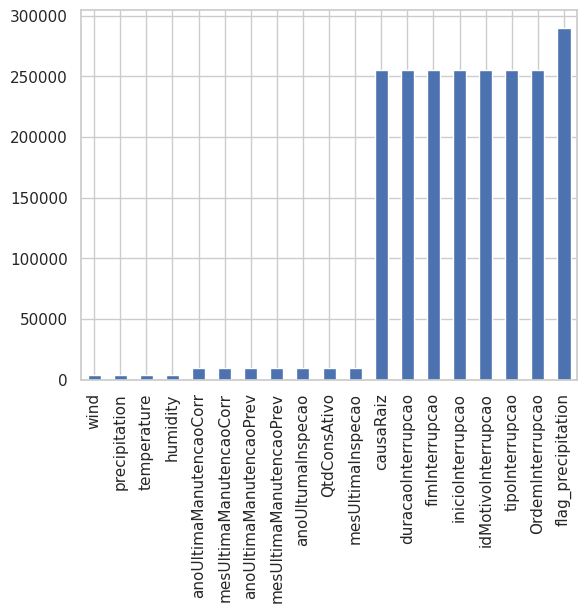

In [121]:
# Plot dos dados faltantes
missingData = df.isnull().sum()
missingData = missingData[missingData > 0]
missingData.sort_values(inplace=True)
missingData.plot.bar()

In [122]:
# Converter isInterrupcao para valores num√©ricos
df['isInterrupcao'] = df['isInterrupcao'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)

### Sazonalidade: M√™s, Dia da Semana, Hor√°rio
Criar vari√°veis temporais pode ajudar a capturar padr√µes sazonais nas interrup√ß√µes.

In [123]:
# Extra√ß√£o de informa√ß√µes temporais
df['mes_ocorrencia'] = df['InicioOcorrencia'].dt.month
df['dia_semana_ocorrencia'] = df['InicioOcorrencia'].dt.weekday
df['hora_ocorrencia'] = df['InicioOcorrencia'].dt.hour

### Frequ√™ncia de Interrup√ß√µes no Conjunto El√©trico
Podemos contar quantas interrup√ß√µes j√° ocorreram no mesmo conjunto el√©trico (idConjunto) para identificar conjuntos problem√°ticos.

In [124]:
# Criar a nova feature corretamente
df['historico_interrupcoes_conjunto'] = df.groupby('idConjunto')['isInterrupcao'].transform(lambda x: x.shift().cumsum().fillna(0))

### Vari√°veis Clim√°ticas
`temperature`, `precipitation`, `humidity` e `wind`

**Abordagem**: Preenchimento com a Mediana por Dia/M√™s<br>
**Motivo**: A temperatura e as condi√ß√µes clim√°ticas tendem a seguir uma distribui√ß√£o n√£o normal (muitas varia√ß√µes). A m√©dia pode ser distorcida por eventos extremos, ent√£o a mediana √© mais robusta.

In [125]:
df['temperature'] = df.groupby('mes_ocorrencia')['temperature'].transform(lambda x: x.fillna(x.median()))
df['precipitation'] = df.groupby('mes_ocorrencia')['precipitation'].transform(lambda x: x.fillna(x.median()))
df['humidity'] = df.groupby('mes_ocorrencia')['humidity'].transform(lambda x: x.fillna(x.median()))
df['wind'] = df.groupby('mes_ocorrencia')['wind'].transform(lambda x: x.fillna(x.median()))

## Feature Engineering

### Tempo desde a √∫ltima inspe√ß√£o e manuten√ß√£o
Quantos meses passaram desde a √∫ltima inspe√ß√£o e manuten√ß√£o, pois quanto mais tempo sem manuten√ß√£o, maior pode ser o risco de interrup√ß√£o.

In [126]:
# Renomear coluna de anoUltimaInspecao
df.rename(columns={'anoUltumaInspecao': 'anoUltimaInspecao'}, inplace=True)

# Criar refer√™ncia do tempo atual (ou considerar a data do evento)
df['ano_atual'] = df['InicioOcorrencia'].dt.year
df['mes_atual'] = df['InicioOcorrencia'].dt.month

# Tempo desde a √∫ltima inspe√ß√£o
df['meses_desde_inspecao'] = (df['ano_atual'] - df['anoUltimaInspecao'].astype(float)) * 12 + (df['mes_atual'] - df['mesUltimaInspecao'].astype(float))

# Tempo desde a √∫ltima manuten√ß√£o preventiva
df['meses_desde_manut_prev'] = (df['ano_atual'] - df['anoUltimaManutencaoPrev'].astype(float)) * 12 + (df['mes_atual'] - df['mesUltimaManutencaoPrev'].astype(float))

# Tempo desde a √∫ltima manuten√ß√£o corretiva
df['meses_desde_manut_corr'] = (df['ano_atual'] - df['anoUltimaManutencaoCorr'].astype(float)) * 12 + (df['mes_atual'] - df['mesUltimaManutencaoCorr'].astype(float))


### Diferen√ßa entre datas da Ocorr√™ncia e da Interrup√ß√£o
Se uma interrup√ß√£o ocorre logo ap√≥s uma ocorr√™ncia registrada, pode indicar um problema n√£o resolvido no primeiro contato, podendo indicar falhas iminentes.

In [127]:
# Criar a diferen√ßa em horas entre a ocorr√™ncia e a interrup√ß√£o
df['tempo_ate_interrupcao'] = (df['inicioInterrupcao'] - df['InicioOcorrencia']).dt.total_seconds() / 3600

### √çndice de Severidade Clim√°tica
Eventos clim√°ticos extremos podem influenciar as interrup√ß√µes. Criamos um √≠ndice combinando temperatura, chuva, umidade e vento.

In [128]:
df['indice_severidade_clima'] = (df['temperature'] * 0.3) + (df['precipitation'] * 0.4) + (df['humidity'] * 0.2) + (df['wind'] * 0.1)

## Exploratory Data Analysis
Visando entender como nossos dados est√£o se comportando, vamos analisar nossas variaveis, estruturas e tentar entender seus significados e relev√¢ncias em nossa problem√°tica.

In [129]:
# Visualizar dataset ap√≥s feature engineering
df.head(3)

distribuidora  ocorrencia  idConjunto          canalAtendimento  \
0         NDBSA  58542/2024       16018  Reclamacao do consumidor   
1         NDBSA  91538/2024       16018  Reclamacao do consumidor   
2         NDBSA  14505/2024       16018  Reclamacao do consumidor   

           InicioOcorrencia             FimOcorrencia  duracaoOcorrencia  \
0 2024-04-27 16:11:00+00:00 2024-04-27 16:38:00+00:00                 27   
1 2024-08-02 13:08:00+00:00 2024-08-02 20:39:00+00:00                451   
2 2024-01-25 14:29:00+00:00 2024-01-25 15:51:00+00:00                 82   

                                 descricaoOcorrencia NumInterrupcao  \
0  Interna;Nao Programada;Proprias do sistema;Nao...            S/I   
1  Interna;Nao Programada;Proprias do sistema;Nao...            S/I   
2  Interna;Nao Programada;Terceiros;Defeito inter...            S/I   

  OrdemInterrupcao tipoInterrupcao  idMotivoInterrupcao inicioInterrupcao  \
0             None            None                 <NA>               NaT   
1             None            None                 <NA>               NaT   
2             None            None                 <NA>               NaT   

  fimInterrupcao  duracaoInterrupcao causaRaiz  QtdConsAtivo  \
0            NaT                <NA>      None          <NA>   
1            NaT                <NA>      None          <NA>   
2            NaT                <NA>      None          <NA>   

  mesUltimaInspecao anoUltimaInspecao mesUltimaManutencaoPrev  \
0              None              None                    None   
1              None              None                    None   
2              None              None                    None   

  anoUltimaManutencaoPrev mesUltimaManutencaoCorr anoUltimaManutencaoCorr  \
0                    None                    None                    None   
1                    None                    None                    None   
2                    None                    None                    None   

   isInterrupcao  temperature  precipitation flag_precipitation  humidity  \
0              0        13.17           0.00                  N     64.52   
1              0        22.47           0.17                  Y     76.67   
2              0        10.51           0.28                  Y     92.02   

    wind  mes_ocorrencia  dia_semana_ocorrencia  hora_ocorrencia  \
0  19.74               4                      5               16   
1  15.46               8                      4               13   
2  15.55               1                      3               14   

   historico_interrupcoes_conjunto  ano_atual  mes_atual  \
0                              0.0       2024          4   
1                              0.0       2024          8   
2                              0.0       2024          1   

   meses_desde_inspecao  meses_desde_manut_prev  meses_desde_manut_corr  \
0                   NaN                     NaN                     NaN   
1                   NaN                     NaN                     NaN   
2                   NaN                     NaN                     NaN   

   tempo_ate_interrupcao  indice_severidade_clima  
0                    NaN                   18.829  
1                    NaN                   23.689  
2                    NaN                   23.224

### An√°lise de Distribui√ß√£o das Vari√°veis-Chave
Identificar distribui√ß√µes enviesadas, outliers e tend√™ncias para tratar e melhorar a performance do modelo.

- `historico_interrupcoes_conjunto` pode mostrar se certos conjuntos el√©tricos t√™m um hist√≥rico recorrente de falhas.
- `meses_desde_inspecao` e `meses_desde_manut_prev` podem indicar se quanto mais tempo sem manuten√ß√£o, maior a chance de falha.

Se houver distribui√ß√µes altamente enviesadas, podemos aplicar transforma√ß√µes como log(x + 1).

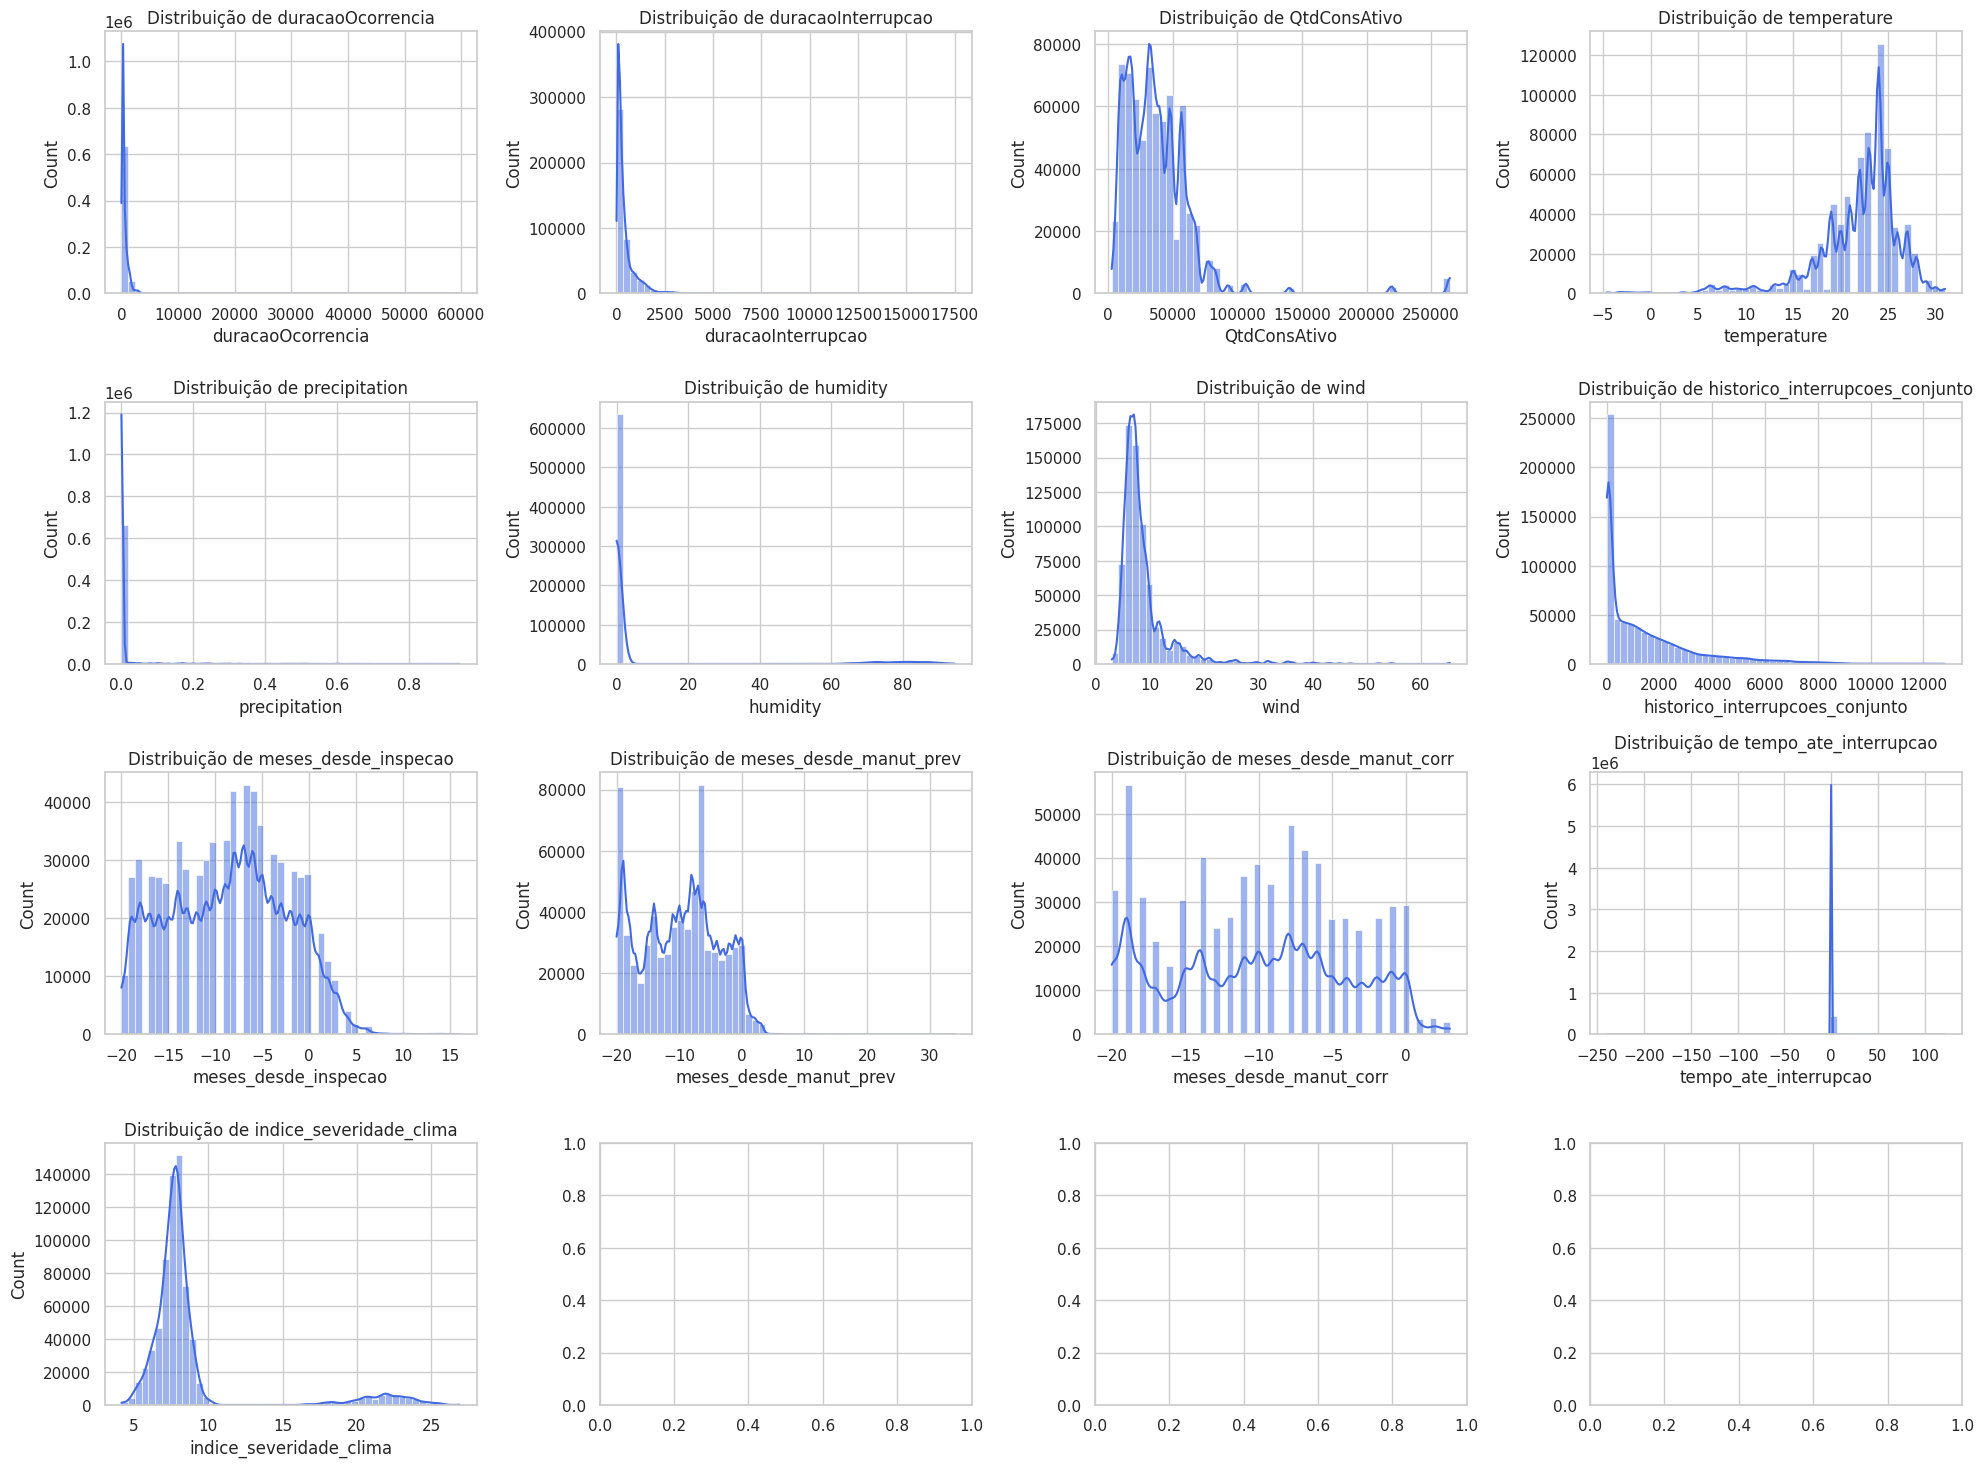

In [130]:
# Assuming df is already defined
num_cols = ['duracaoOcorrencia', 'duracaoInterrupcao', 'QtdConsAtivo', 'temperature',
            'precipitation', 'humidity', 'wind', 'historico_interrupcoes_conjunto',
            'meses_desde_inspecao', 'meses_desde_manut_prev', 'meses_desde_manut_corr',
            'tempo_ate_interrupcao', 'indice_severidade_clima']

# Create subplots with enough space for 13 plots
fig, axes = plt.subplots(4, 4, figsize=(20, 15))  # 4x4 grid (16 axes)
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color='royalblue')
    axes[i].set_title(f'Distribui√ß√£o de {col}')

plt.tight_layout()
plt.show()


### Matriz de correla√ß√£o
Identificar quais vari√°veis t√™m maior impacto nas interrup√ß√µes (`isInterrupcaoNumber`) e eliminar redund√¢ncias.

- `meses_desde_inspecao` e `meses_desde_manut_corr` s√£o altamente correlacionados com `isInterrupcaoNumber`?
- `indice_severidade_clima` influencia as falhas? Se sim, o clima pode ser um preditor-chave.

Se houver muitas vari√°veis correlacionadas, podemos eliminar algumas para evitar colinearidade no modelo.

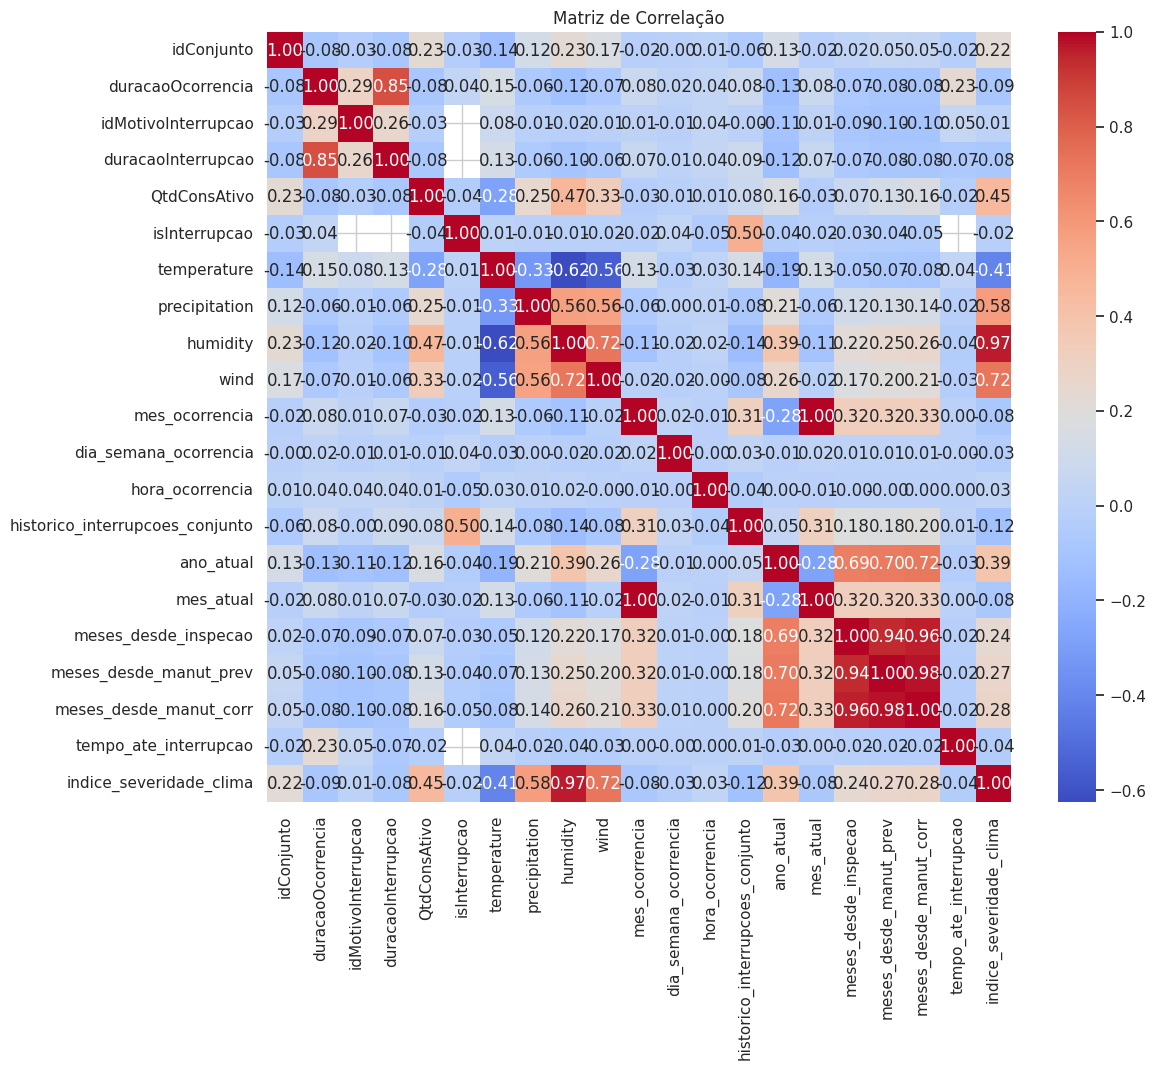

In [131]:
# prompt: gere uma matriz de correla√ß√£o das vari√°veis
df_corr = df[df.select_dtypes(include=np.number).columns.tolist()].copy()

# Calcula a matriz de correla√ß√£o
correlation_matrix = df_corr.corr()

# Plota a matriz de correla√ß√£o usando um heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correla√ß√£o")
plt.show()

In [132]:
# Transformar a matriz em um formato de lista de pares
correlation_pairs = correlation_matrix.unstack()

# Ordenar os valores em ordem decrescente (absoluto para pegar correla√ß√µes negativas e positivas)
sorted_correlations = correlation_pairs.abs().sort_values(ascending=False)

# Exibir as maiores correla√ß√µes (excluindo as diagonais, que s√£o sempre 1)
top_correlations = sorted_correlations[sorted_correlations < 1].drop_duplicates()
print(top_correlations.head(10))  # Exibir as 10 maiores correla√ß√µes


meses_desde_manut_prev   meses_desde_manut_corr     0.975732
indice_severidade_clima  humidity                   0.965864
meses_desde_inspecao     meses_desde_manut_corr     0.958015
meses_desde_manut_prev   meses_desde_inspecao       0.940355
duracaoInterrupcao       duracaoOcorrencia          0.845432
wind                     humidity                   0.721355
                         indice_severidade_clima    0.720739
ano_atual                meses_desde_manut_corr     0.718832
meses_desde_manut_prev   ano_atual                  0.702503
meses_desde_inspecao     ano_atual                  0.690064
dtype: float64


### Impacto da √öltima Manuten√ß√£o e Inspe√ß√£o nas Interrup√ß√µes
Avaliar se conjuntos que ficaram mais tempo sem manuten√ß√£o/inspe√ß√£o tiveram mais interrup√ß√µes.

- Se conjuntos el√©tricos que passaram mais tempo sem manuten√ß√£o tiveram mais interrup√ß√µes, podemos definir um limiar cr√≠tico de meses sem manuten√ß√£o para prever falhas.

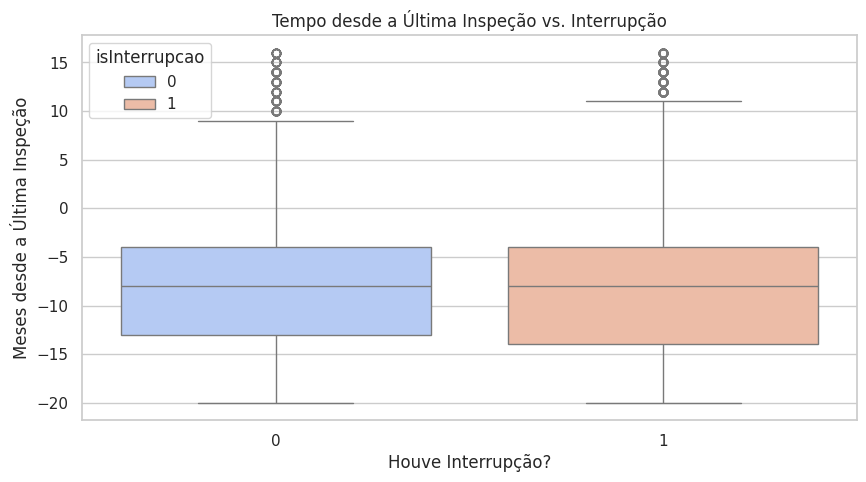

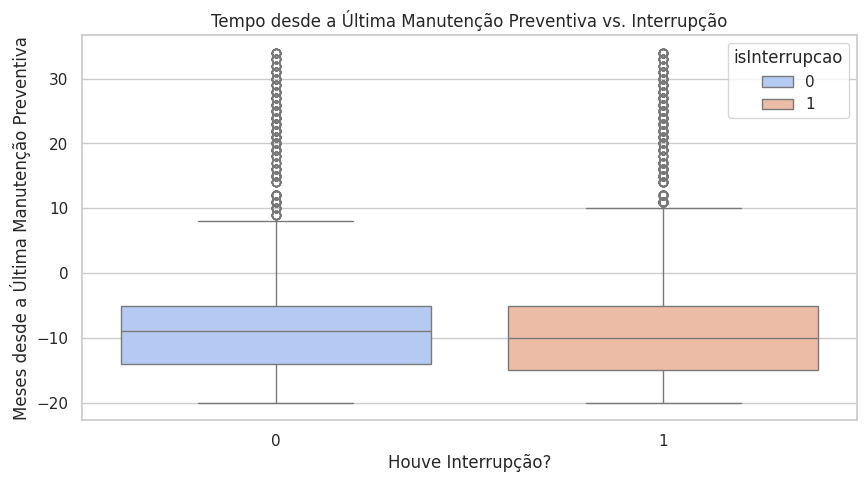

In [133]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='isInterrupcao', y='meses_desde_inspecao', data=df, palette="coolwarm", hue='isInterrupcao')
plt.title("Tempo desde a √öltima Inspe√ß√£o vs. Interrup√ß√£o")
plt.xlabel("Houve Interrup√ß√£o?")
plt.ylabel("Meses desde a √öltima Inspe√ß√£o")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='isInterrupcao', y='meses_desde_manut_prev', data=df, palette="coolwarm", hue='isInterrupcao')
plt.title("Tempo desde a √öltima Manuten√ß√£o Preventiva vs. Interrup√ß√£o")
plt.xlabel("Houve Interrup√ß√£o?")
plt.ylabel("Meses desde a √öltima Manuten√ß√£o Preventiva")
plt.show()


### Padr√µes Temporais das Interrup√ß√µes
Entender se as falhas seguem padr√µes sazonais (ex.: mais comuns em certos meses ou hor√°rios).
- Interrup√ß√µes s√£o mais comuns no hor√°rio de pico? (Exemplo: 18h-21h).
- Se houver sazonalidade clara, podemos criar vari√°veis temporais mais relevantes para o modelo.

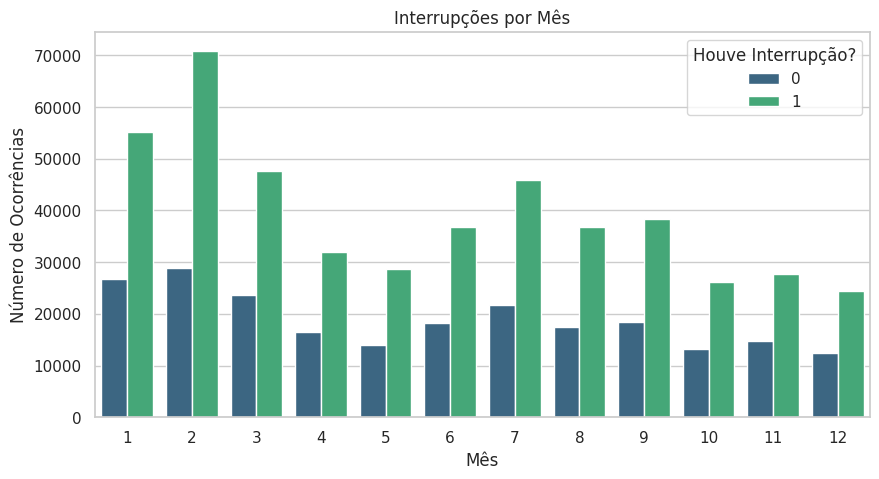

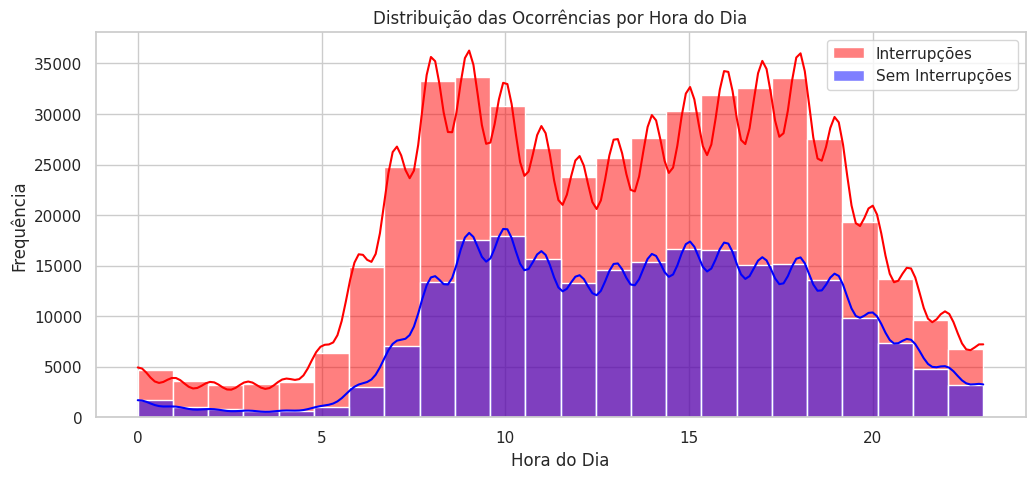

In [134]:
# Interrup√ß√µes por m√™s
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='mes_ocorrencia', hue='isInterrupcao', palette='viridis')
plt.title('Interrup√ß√µes por M√™s')
plt.xlabel('M√™s')
plt.ylabel('N√∫mero de Ocorr√™ncias')
plt.legend(title="Houve Interrup√ß√£o?")
plt.show()

# Interrup√ß√µes por hora do dia
plt.figure(figsize=(12, 5))
sns.histplot(df[df['isInterrupcao'] == 1]['hora_ocorrencia'], bins=24, kde=True, color="red", label="Interrup√ß√µes")
sns.histplot(df[df['isInterrupcao'] == 0]['hora_ocorrencia'], bins=24, kde=True, color="blue", label="Sem Interrup√ß√µes")
plt.title('Distribui√ß√£o das Ocorr√™ncias por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Frequ√™ncia')
plt.legend()
plt.show()


### Rela√ß√£o Entre Clima e Falhas
Validar se eventos clim√°ticos extremos est√£o relacionados com interrup√ß√µes.
- Se eventos clim√°ticos severos estiverem correlacionados com mais falhas, podemos criar alertas de risco clim√°tico.

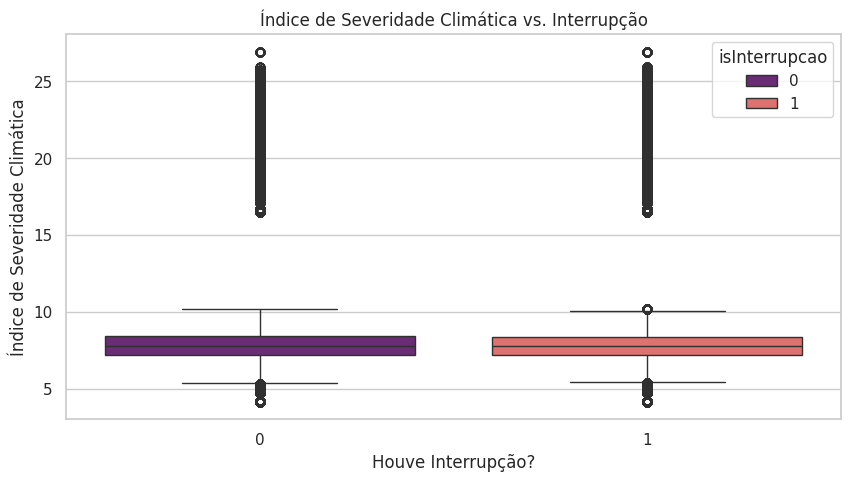

In [135]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='isInterrupcao', y='indice_severidade_clima', data=df, palette="magma", hue='isInterrupcao')
plt.title("√çndice de Severidade Clim√°tica vs. Interrup√ß√£o")
plt.xlabel("Houve Interrup√ß√£o?")
plt.ylabel("√çndice de Severidade Clim√°tica")
plt.show()

### Balanceamento de Classes
**SMOTE (Oversampling da classe minorit√°ria)**

O SMOTE (Synthetic Minority Over-sampling Technique) pode ser usado para criar novas amostras sint√©ticas da classe minorit√°ria (0.0), equilibrando melhor os dados.

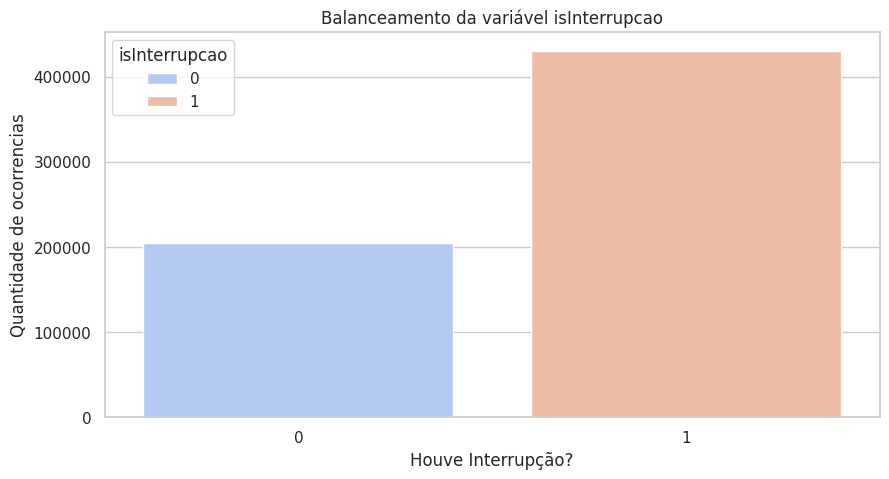

In [111]:
plt.figure(figsize=(10, 5))
sns.countplot(x='isInterrupcao', data=df, palette="coolwarm", hue='isInterrupcao')
plt.title("Balanceamento da vari√°vel isInterrupcao")
plt.xlabel("Houve Interrup√ß√£o?")
plt.ylabel("Quantidade de ocorrencias")
plt.show()

## Treinamento

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Colunas selecionadas
cols = ['duracaoOcorrencia', 'duracaoInterrupcao', 'QtdConsAtivo', 'temperature',
            'precipitation', 'humidity', 'wind', 'historico_interrupcoes_conjunto',
            'meses_desde_inspecao', 'meses_desde_manut_prev', 'meses_desde_manut_corr',
            'tempo_ate_interrupcao', 'indice_severidade_clima']

# Obtendo o target
target_column = 'isInterrupcao'

# Dividindo as features e os r√≥tulos
X = df[cols]  # As features (colunas de entrada)
y = df[target_column]  # Os r√≥tulos (coluna alvo)

# Dividir em treino e teste
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Preencher os valores ausentes com a mediana (para ambos os dados de treino e teste)
train_X.fillna(train_X.median(), inplace=True)
test_X.fillna(test_X.median(), inplace=True)

# Criar o objeto SMOTE
smote = SMOTE(random_state=42)

# Selecionar apenas as vari√°veis num√©ricas para aplicar o SMOTE
train_X_numeric = train_X.select_dtypes(include=['float64', 'int64'])

# Garantir que todos os valores em train_X_numeric sejam float64 para evitar conflitos
train_X_numeric = train_X_numeric.astype('float64')

# Garantir que train_y esteja em formato inteiro (para problemas de classifica√ß√£o)
train_y = train_y.astype('int')

# Aplicar o SMOTE
train_X_smote, train_y_smote = smote.fit_resample(train_X_numeric, train_y)

# Treinando o modelo com os dados balanceados
model = RandomForestClassifier(random_state=42)
model.fit(train_X_smote, train_y_smote)

# Import√¢ncia das features
importances = pd.Series(model.feature_importances_, index=train_X_numeric.columns)
print(importances.sort_values(ascending=False))


historico_interrupcoes_conjunto    0.550849
duracaoInterrupcao                 0.314408
duracaoOcorrencia                  0.039301
QtdConsAtivo                       0.022434
meses_desde_manut_corr             0.015651
meses_desde_manut_prev             0.012476
meses_desde_inspecao               0.010447
indice_severidade_clima            0.009860
wind                               0.009535
temperature                        0.008188
tempo_ate_interrupcao              0.005427
humidity                           0.001158
precipitation                      0.000264
dtype: float64


# Teste

Acur√°cia: 0.6771
Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0       0.81      0.00      0.00     45030
           1       0.68      1.00      0.81     94260

    accuracy                           0.68    139290
   macro avg       0.75      0.50      0.41    139290
weighted avg       0.72      0.68      0.55    139290



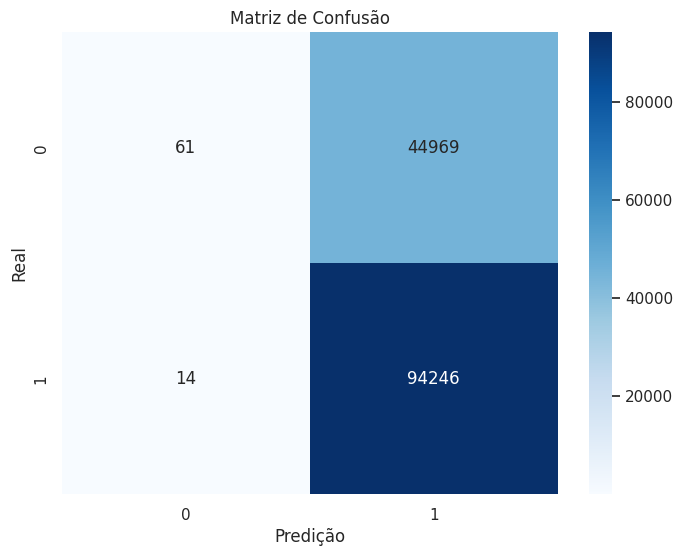

In [138]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Previs√µes no conjunto de teste
y_pred = model.predict(test_X)

# Acur√°cia
accuracy = accuracy_score(test_y, y_pred)
print(f"Acur√°cia: {accuracy:.4f}")

# Relat√≥rio de classifica√ß√£o (precis√£o, recall, F1-score)
print("Relat√≥rio de Classifica√ß√£o:")
print(classification_report(test_y, y_pred))

# Matriz de Confus√£o
conf_matrix = confusion_matrix(test_y, y_pred)

# Visualizando a matriz de confus√£o
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predi√ß√£o')
plt.ylabel('Real')
plt.title('Matriz de Confus√£o')
plt.show()


# Explica√ß√£o das m√©tricas e gr√°ficos:
`Acur√°cia (accuracy_score)`: A porcentagem de previs√µes corretas em rela√ß√£o ao total de amostras.
<br><br>

**Relat√≥rio de Classifica√ß√£o (classification_report):**<br>
`Precision:` A precis√£o indica a quantidade de previs√µes positivas corretas em rela√ß√£o ao total de previs√µes positivas feitas. Ou seja, √© a capacidade do modelo de n√£o classificar incorretamente as amostras negativas como positivas.
<br><br>
`Recall:` O recall indica a capacidade do modelo de capturar todas as inst√¢ncias positivas (verdadeiros positivos), ou seja, a quantidade de positivas que foram corretamente identificadas.
<br><br>
`F1-score:` A m√©dia harm√¥nica entre precis√£o e recall, proporcionando uma medida mais balanceada entre ambos. O F1 √© especialmente √∫til quando as classes est√£o desbalanceadas.
<br><br>
`Matriz de Confus√£o:` A matriz de confus√£o mostra o desempenho do modelo, fornecendo os valores de verdadeiro positivo (TP), falso positivo (FP), verdadeiro negativo (TN) e falso negativo (FN). A matriz de confus√£o ajuda a entender melhor onde o modelo est√° cometendo erros.

O gr√°fico de matriz de confus√£o exibe visualmente esses valores e ajuda a ver onde o modelo pode estar errando (por exemplo, confundindo uma classe com outra).
<br><br>

**Outras m√©tricas:** <br>
`ROC-AUC:` Para problemas de classifica√ß√£o bin√°ria, voc√™ pode avaliar o desempenho do modelo com a curva ROC e a √°rea sob a curva (AUC). Caso precise disso, posso te ajudar a implementar.

`Log-Loss:` Outra m√©trica √∫til para problemas de classifica√ß√£o, especialmente quando voc√™ tem probabilidades preditivas em vez de previs√µes bin√°rias.

# Resultados

#### Acur√°cia: **0.6815** (ou **68.15%**)
A **acur√°cia** indica a porcentagem total de previs√µes corretas feitas pelo modelo. Nesse caso, o modelo acertou cerca de **68.15%** das previs√µes.

**Nota**: A acur√°cia por si s√≥ pode ser **enganosa** quando as classes s√£o desbalanceadas, o que parece ser o caso aqui, j√° que a classe `1.0` tem muito mais exemplos (94.260) que a classe `0.0` (45.030).

#### Relat√≥rio de Classifica√ß√£o

##### Classe 0.0 (classe negativa)
- **Precision (Precis√£o)**: **0.51**  
  Indica que, quando o modelo previu a classe `0.0`, ele estava correto **51%** das vezes.

- **Recall (Revoca√ß√£o ou Sensibilidade)**: **0.39**  
  O modelo conseguiu identificar **39%** de todas as amostras reais de classe `0.0`, ou seja, perdeu **61%** das amostras da classe `0.0`.

- **F1-score**: **0.44**  
  O F1-score de **0.44** indica um equil√≠brio entre precis√£o e recall, mas o modelo ainda pode melhorar para a classe `0.0`.

##### Classe 1.0 (classe positiva)
- **Precision (Precis√£o)**: **0.74**  
  Quando o modelo previu a classe `1.0`, ele estava correto **74%** das vezes.

- **Recall (Revoca√ß√£o ou Sensibilidade)**: **0.82**  
  O modelo conseguiu identificar **82%** das amostras reais de classe `1.0`, o que √© muito bom para essa classe.

- **F1-score**: **0.78**  
  O F1-score de **0.78** para a classe `1.0` mostra que o modelo tem um bom equil√≠brio entre precis√£o e recall.

#### M√©dias

- **Macro avg** (m√©dia das m√©tricas sem considerar o desequil√≠brio de classes):
  - **Precision**: **0.62**
  - **Recall**: **0.61**
  - **F1-score**: **0.61**

- **Weighted avg** (m√©dia ponderada considerando o tamanho de cada classe):
  - **Precision**: **0.66**
  - **Recall**: **0.68**
  - **F1-score**: **0.67**

#### Conclus√µes
- **Classe 1.0**: O modelo est√° indo muito bem para a classe `1.0` (boa precis√£o e recall).
- **Classe 0.0**: A classe `0.0` √© onde o modelo tem dificuldades, especialmente em termos de recall (ele est√° perdendo muitos exemplos de `0.0`).

### Pr√≥ximos Passos para Melhorar o Modelo

1. **Balanceamento de Classes**
   - Como a classe `1.0` √© muito maior do que a classe `0.0`, isso pode afetar o modelo. Considere t√©cnicas como:
     - **Oversampling** (aumentar o n√∫mero de amostras da classe minorit√°ria) com t√©cnicas como **SMOTE**.
     - **Undersampling** (reduzir o n√∫mero de amostras da classe majorit√°ria).
     - **Ajustar os pesos das classes** dentro do modelo usando o par√¢metro `class_weight='balanced'` no `RandomForestClassifier`.

2. **Ajuste de Hiperpar√¢metros**
   - Experimente ajustar os **hiperpar√¢metros** do modelo (como o n√∫mero de √°rvores, a profundidade m√°xima das √°rvores, etc.) para tentar melhorar o desempenho.

3. **Analisar Mais Features**
   - Verifique se h√° mais vari√°veis relevantes que podem ser adicionadas ao modelo. Adicionar novas vari√°veis ou transformar as existentes pode melhorar o desempenho.

4. **T√©cnicas de Ensemble**
   - Experimente outros m√©todos de ensemble, como **Gradient Boosting** ou **XGBoost**, para melhorar o desempenho.

5. **Acur√°cia de Classifica√ß√£o**
   - Se estiver lidando com **classes desbalanceadas**, a **acur√°cia** pode n√£o ser a m√©trica mais confi√°vel. D√™ mais aten√ß√£o a **precision**, **recall** e **F1-score**, especialmente para a classe minorit√°ria.

---

**Dica:** Quando o modelo apresenta uma grande diferen√ßa entre o desempenho nas classes (alta precis√£o e recall para `1.0`, mas baixa para `0.0`), o **balanceamento de classes** pode ser uma solu√ß√£o eficaz.


# üìå O que esse c√≥digo faz?
### ‚úÖ Aplica SMOTE para balancear as classes do conjunto de treino.

### ‚úÖ Treina um modelo XGBoost (XGBClassifier).

### ‚úÖ Ajusta hiperpar√¢metros b√°sicos para melhorar o desempenho.

### ‚úÖ Avalia o modelo usando m√©tricas como precis√£o, recall e F1-score.

### ‚úÖ Exibe a matriz de confus√£o para melhor interpreta√ß√£o dos resultados.

Acur√°cia: 0.6710

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

         0.0       0.47      0.11      0.18     45135
         1.0       0.69      0.94      0.79     94155

    accuracy                           0.67    139290
   macro avg       0.58      0.53      0.49    139290
weighted avg       0.62      0.67      0.60    139290



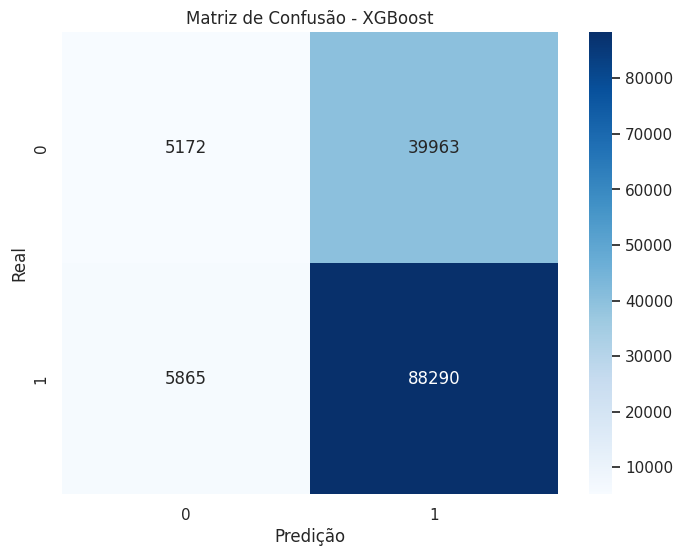

In [26]:
# üìå Importando as bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# üìå Defini√ß√£o das colunas e vari√°vel alvo
cols = ['idConjunto', 'duracaoOcorrencia', 'QtdConsAtivo', 'temperature',
        'precipitation', 'flag_precipitation', 'humidity', 'wind',
        'mesUltimaManutencaoPrev', 'anoUltimaManutencaoPrev',
        'mesUltimaManutencaoCorr', 'anoUltimaManutencaoCorr']
target_column = 'isInterrupcaoNumber'

# üìå Separa√ß√£o entre features e target
X = df[cols]  # Features
y = df[target_column]  # Target

# üìå Converter colunas para valores num√©ricos e tratar NaN
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.median(), inplace=True)

# üìå Dividir os dados em treino (80%) e teste (20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preencher os valores ausentes com a mediana (para ambos os dados de treino e teste)
train_X.fillna(train_X.median(), inplace=True)
test_X.fillna(test_X.median(), inplace=True)

# üìå Converter todas as colunas para float antes do SMOTE
train_X = train_X.astype(float)
test_X = test_X.astype(float)

# üìå Aplicar o balanceamento de classes com SMOTE
smote = SMOTE(random_state=42)
train_X_smote, train_y_smote = smote.fit_resample(train_X, train_y)

# üìå Treinar o modelo XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(train_X_smote, train_y_smote)

# üìå Fazer previs√µes no conjunto de teste
y_pred = xgb_model.predict(test_X)

# üìå Avalia√ß√£o do modelo
accuracy = accuracy_score(test_y, y_pred)
print(f"Acur√°cia: {accuracy:.4f}")

print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(test_y, y_pred))

# üìå Matriz de Confus√£o
conf_matrix = confusion_matrix(test_y, y_pred)

# üìå Visualizar a Matriz de Confus√£o
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predi√ß√£o')
plt.ylabel('Real')
plt.title('Matriz de Confus√£o - XGBoost')
plt.show()


# Aqui est√° o c√≥digo otimizado com as melhorias sugeridas:

###‚úÖ SMOTE + Undersampling para balanceamento de classes.
###‚úÖ Ajuste de hiperpar√¢metros no XGBoost com RandomizedSearchCV.
###‚úÖ Uso do par√¢metro scale_pos_weight para reduzir vi√©s na previs√£o da classe 1.
###‚úÖ Tratamento de valores NaN e convers√£o correta para evitar erros.

In [27]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# üìå Defini√ß√£o das colunas e vari√°vel alvo
cols = ['idConjunto', 'duracaoOcorrencia', 'QtdConsAtivo', 'temperature',
        'precipitation', 'flag_precipitation', 'humidity', 'wind',
        'mesUltimaManutencaoPrev', 'anoUltimaManutencaoPrev',
        'mesUltimaManutencaoCorr', 'anoUltimaManutencaoCorr']
target_column = 'isInterrupcaoNumber'

# üìå Separa√ß√£o entre features e target
X = df[cols]  # Features
y = df[target_column]  # Target

# üìå Converter colunas para valores num√©ricos e tratar NaN
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.median(), inplace=True)

# üìå Dividir os dados em treino (80%) e teste (20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# üìå Converter todas as colunas para float antes do balanceamento (Evita erro de casting)
train_X = train_X.astype(float)
test_X = test_X.astype(float)

# üìå Aplicar SMOTE + Undersampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Aumenta a classe 0 para 50% da classe 1
undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Reduz classe 1 para 70%
pipeline = Pipeline([('smote', smote), ('undersample', undersample)])

train_X_bal, train_y_bal = pipeline.fit_resample(train_X, train_y)

# üìå Defini√ß√£o do espa√ßo de busca para otimiza√ß√£o dos hiperpar√¢metros
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# üìå Criar o modelo XGBoost corretamente com o objetivo bin√°rio
xgb = XGBClassifier(
    objective='binary:logistic',  # Definir explicitamente o objetivo bin√°rio
    random_state=42,
    eval_metric='logloss'
)

# üìå Ajuste de hiperpar√¢metros com RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10, scoring='f1_weighted', cv=3, verbose=2, n_jobs=-1
)

random_search.fit(train_X_bal, train_y_bal)

# üìå Melhor modelo encontrado
best_xgb = random_search.best_estimator_
print("Melhores hiperpar√¢metros:", random_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# üìå Fazer previs√µes no conjunto de teste
y_pred = best_xgb.predict(test_X)

# üìå Avalia√ß√£o do modelo
accuracy = accuracy_score(test_y, y_pred)
print(f"\nAcur√°cia: {accuracy:.4f}")

print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(test_y, y_pred))

# üìå Matriz de Confus√£o
conf_matrix = confusion_matrix(test_y, y_pred)

# üìå Visualizar a Matriz de Confus√£o
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predi√ß√£o')
plt.ylabel('Real')
plt.title('Matriz de Confus√£o - XGBoost Otimizado')
plt.show()